# Main Comparison Plots

# Switching Time Chart

In [54]:
import glob
import json
import pandas as pd
file_list = glob.glob("switching*")

columns=['name', 'num_configs', "ram(MB)", "disk_load(ms)", "warmup(ms)"]
num_configs_dict = {
    "assine2022b": 16,
    "assine2022a": 12,
    "matsubara2022": 4,
    "lee2021": 5,
}

rows = []

for file in file_list:
    with open(file, "r") as fp:
        data = json.load(fp)
        name = file.split('switching_result_')[1].split(".json")[0]
        num_configs = num_configs_dict[name]
        ram = data["ram"]*1000
        disk_load = sum([l["disk_load"] for l in data["lists"]])
        warmup = sum([l["warmup"] for l in data["lists"]])
        row = [name, num_configs, ram, disk_load, warmup]
        rows.append(row)
        
    

df = pd.DataFrame(rows, columns=columns)
df = df.set_index("name")
df = df.round(1)
print(df)
# print(df.to_latex())

               num_configs  ram(MB)  disk_load(ms)  warmup(ms)
name                                                          
assine2022b             16     85.7          954.0      1811.5
assine2022a             12    204.9         1207.0      9913.6
matsubara2022            4    239.9          709.9     12785.1
lee2021                  5    153.4         1264.5      5045.5


## Dynamic Behaviour


In [29]:
!pip install jsonlines
!ls

output.jsonl			   switching_result_assine2022b.json
plots.ipynb			   switching_result_lee2021.json
rpi4_cpus4.csv			   switching_result_matsubara2022.json
switching_result_assine2022a.json


In [38]:
import jsonlines

with jsonlines.open('output.jsonl') as reader:
    bw = [obj["bw"] for obj in reader]

with jsonlines.open('output.jsonl') as reader:
    e2e = [obj["e2e"] for obj in reader]
    

with jsonlines.open('output.jsonl') as reader:
    mAP = [obj["map"] for obj in reader]
    

ignore_start = 10
bw = bw[ignore_start:]
e2e = e2e[ignore_start:]
mAP = mAP[ignore_start:]



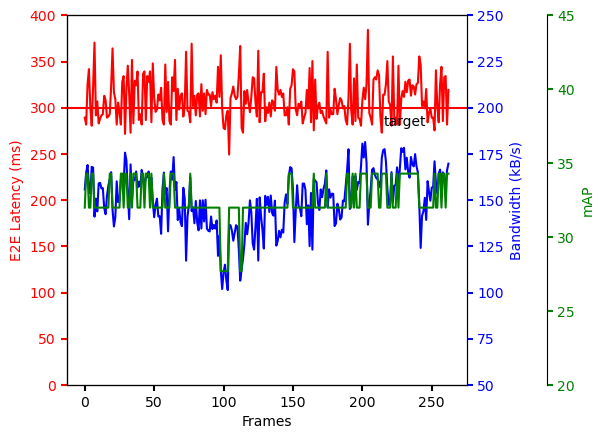

In [86]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.subplots_adjust(right=0.75)
twin1 = ax.twinx()
twin2 = ax.twinx()


twin2.spines.right.set_position(("axes", 1.2))

p1, = ax.plot(e2e, "r-", label="E2E Latency")
p2, = twin1.plot(bw, "b-", label="Bandwidth(kB/s)")
p3, = twin2.plot(mAP, "g-", label="mAP")


ax.text(215, 280, "target")
ax.axhline(y = 300, color = 'r', linestyle = '-')

ax.set_ylim(0, 400)
twin1.set_ylim(50, 250)
twin2.set_ylim(20, 45)


ax.set_xlabel("Frames")
ax.set_ylabel("E2E Latency (ms)")
twin1.set_ylabel("Bandwidth (kB/s)")
twin2.set_ylabel("mAP")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)
